In [98]:
import numpy as np
from numpy import pi
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.visualization.utils import _get_layered_instructions

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Additional imports for audio
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output
from ipywidgets import widgets
from functools import partial
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-05-18 10:31:35,995: Credentials are already in use. The existing account in the session will be replaced.


In [83]:
"""Plays a note from each column of the circuit"""

'Plays a note from each column of the circuit'

In [108]:
"""Global variables and utility functions"""

# Simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Utility functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

def get_amplitudes(matrix):
    return abs(matrix)

def get_phases(matrix):
    return np.angle(matrix)

# Pretty-printing
def print_matrix(matrix):
    print('Matrix shape ', matrix.shape)
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_vector(vector, comment=''):
    print(f'Vector {comment} with shape {vector.shape}')
    for num in vector:
        print(np.around(num, 2))
    print('---')
    
def get_circuits_by_column(circuit):
    """circuit-splitter.ipynb"""
    # Get circuit metadata
    num_qubits = circuit.num_qubits
    num_clbits = circuit.num_clbits
    _, _, ops = _get_layered_instructions(circuit)
    num_columns = len(ops)
    
    # Initialize column information
    curr_column = [0] * num_qubits
    columns = []
    for i in range(num_columns):
        columns.append([])
        
    # Organize instructions by column
    for (insn, qargs, cargs) in circuit.data:    
        col = -1
        anchor_qubit = -1
        for qubit in qargs:
            index = qubit.index
            if curr_column[index] > col:
                col = curr_column[index]
                anchor_qubit = index
        if col == -1 or anchor_qubit == -1:
            print('Something went wrong...')
            continue

        columns[col].append((insn, qargs, cargs))
        curr_column[anchor_qubit] += 1
        for qubit in qargs:
            index = qubit.index
            curr_column[index] = curr_column[anchor_qubit]
        
    # Build the subcircuits by column
    sub_circuits = []
    for col in range(0, num_columns):
        sub_circuit = QuantumCircuit(num_qubits, num_clbits)
        for (insn, qargs, cargs) in columns[col]:
            sub_circuit.append(insn, qargs, cargs)
        sub_circuits.append(sub_circuit)

    assert len(sub_circuits) == num_columns
    return sub_circuits

"""Audio variables and functions"""
def synth(frequency):
    rate = 16000.0
    duration = 0.25
    x = np.linspace(0.0, duration, int(rate * duration))

    y = np.sin(frequency * 2.0 * np.pi * x)
    display(Audio(y, rate=rate, autoplay=True))

# Start with middle C = C4
# Each note increments by a phase of pi/4
# https://pages.mtu.edu/~suits/notefreqs.html#:~:text=Frequencies%20of%20Musical%20Notes%2C%20A4%20%3D%20440%20Hz
c_scale = {
    round(0, 2): ('C4', 261.63),
    round(pi/4, 2): ('D4', 293.66),
    round(2*pi/4, 2): ('E4', 329.63),
    round(3*pi/4, 2): ('F4', 349.23),
    round(4*pi/4, 2): ('G4', 392.00),
    round(-pi/4, 2): ('A4', 440.00), # after pi, phases are negative
    round(-2*pi/4, 2): ('B4', 493.88),
    round(-3*pi/4, 2): ('C5', 523.25)
}

def get_note(phase):
    """Return music note given a phase"""
    # Round to the nearest multiple of pi/4
    base = pi/4
    key = round(base * round(phase/base), 2)
    if key not in c_scale:
        print(f'{key} not in scale!')
        return None
    
    return c_scale[key]

In [109]:
# Test get_note()
phases_c_scale = [
    (0, 'C4'),
    (pi/4, 'D4'),
    (pi/2, 'E4'),
    (-pi/4, 'A4')
]
for (phase, note) in phases_c_scale:
    note = get_note(phase)
    print('Correct?: ', note)

note ('D4', 293.66)


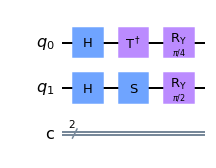

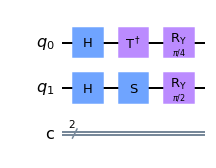

In [102]:
"""Insert circuit in this cell"""

qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];

h q[0];
h q[1];
tdg q[0];
s q[1];
ry(pi/4) q[0];
ry(pi/2) q[1];
"""

circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.draw()

In [103]:
# Get circuits by column
sub_circuits = get_circuits_by_column(circuit)

<ipython-input-101-f58a911e79ef>:54: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index
<ipython-input-101-f58a911e79ef>:65: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index


In [104]:
# Use first column as the starting state vector
state_vector = get_state_vector(sub_circuits[0])
print_vector(state_vector)

print_vector(get_amplitudes(state_vector))

Vector  with shape (4,)
(0.5+0j)
(0.5+0j)
(0.5+0j)
(0.5+0j)
---
Vector  with shape (4,)
0.5
0.5
0.5
0.5
---


In [72]:
synth(440) # 440Hz ~ A4 note

In [8]:
# # Commented out because sometimes the notes play at the same time and it sounds horrible.
# # Play a simple tune
# notes = [
#     ('A', 880),
#     ('A', 880),
#     ('A', 880),
#     ('F#', 739.99),
#     ('D', 1174.66)
# ]
# for (note, frequency) in notes:
#     synth(frequency)
#     # sleep(0.50) # prevents notes from playing at the same time